## Import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy import stats
import time
import matplotlib.pyplot as plt

## Preprocess

In [2]:
df_all_rating_fix_all_info = pd.read_excel('dataset/data_all_rating_fix_all_info.xlsx')
df_all_rating_fix_all_info= df_all_rating_fix_all_info[['idUser','idFilm','rRating']]
df_all_rating_fix_all_info.columns = [0, 1, 2]
df_all_rating_fix_all_info

,0,1,2
0,1,2,2.65
1,1,5,2.92
2,1,8,2.64
3,1,18,2.58
4,1,26,3.71
...,...,...,...
6178,35,787,3.70
6179,35,788,2.45
6180,35,789,3.45
6181,35,790,3.15


In [3]:
df_all_rating_fix_all_info[df_all_rating_fix_all_info[0]==2]

,0,1,2
60,2,34,4.00
61,2,136,5.00
62,2,145,2.75
63,2,251,4.25
64,2,270,3.12
65,2,306,3.72
66,2,308,2.60
67,2,389,3.32
68,2,391,3.88
69,2,459,2.00


In [4]:
df_all_rating_fix_all_info.describe()

,0,1,2
count,6183.000000,6183.000000,6183.000000
mean,24.128417,407.933527,3.007660
std,11.127929,233.426764,0.847197
min,1.000000,1.000000,0.000000
25%,11.000000,189.500000,2.500000
50%,30.000000,413.000000,3.000000
75%,33.000000,608.000000,3.550000
max,35.000000,791.000000,5.000000


In [5]:
user_num = 35
item_num = 791
def get_eval_matrix(df):

    ret = np.zeros((user_num, item_num))
    for i, data in df.iterrows():
        ret[int(data[0] - 1)][int(data[1] - 1)] = data[2]
    return ret

In [6]:
#make user-item-evaluate matrix
all_mat = get_eval_matrix(df_all_rating_fix_all_info)

In [7]:
all_mat

array([[0.  , 2.65, 0.  , ..., 0.  , 2.44, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 2.92, 0.  ],
       [0.  , 3.5 , 0.  , ..., 0.  , 3.33, 3.5 ],
       ...,
       [3.45, 3.  , 3.7 , ..., 3.25, 2.75, 2.55],
       [0.  , 4.25, 0.  , ..., 2.7 , 1.7 , 2.05],
       [0.  , 3.75, 0.  , ..., 3.45, 3.15, 2.25]])

In [8]:
all_mat.shape

(35, 791)

## User-Based Collaborative Filtering

### Mencari n terbaik untuk User-Based Collaborative Filtering

In [13]:
##Menghitung similarity
def funcSimCF(u,matx,n):
    listtest=[]
    for i in range(len(matx)):
        listtest.append([i+1,stats.pearsonr(matx[u-1],matx[i])[0]])
    listtest.sort(key=lambda row: (row[1]), reverse=True)
    listtest= listtest[1:n+1]
    return listtest

In [14]:
##Menghitung rata-rata
def rataU_nonzero(u,matx):
    return matx[u-1].sum()/np.count_nonzero(matx[u-1])

In [15]:
##Menghitung Prediksi UCF
def predCF(u,i,n,matx):
    matx_temp = matx.copy()
    matx_temp[u-1][i-1]=0
    rataU = rataU_nonzero(u,matx_temp)
    atas=0
    bawah=0
    similarU = funcSimCF(u,matx_temp,n)
    for sim in similarU:
        atas += sim[1] *(matx_temp[sim[0]-1][i-1] - rataU_nonzero(sim[0],matx_temp))
        bawah+= sim[1]
    return(rataU+(atas/bawah))

In [16]:
df_all = df_all_rating_fix_all_info.copy()
df_all.describe()

,0,1,2
count,6183.000000,6183.000000,6183.000000
mean,24.128417,407.933527,3.007660
std,11.127929,233.426764,0.847197
min,1.000000,1.000000,0.000000
25%,11.000000,189.500000,2.500000
50%,30.000000,413.000000,3.000000
75%,33.000000,608.000000,3.550000
max,35.000000,791.000000,5.000000


In [17]:
##Mencari best-n UCF
df_all = df_all_rating_fix_all_info.copy()
listpredCF=[]
for n in range(1,15+1):
    ratPredCF = []
    for idx in range(len(df_all)):
        userSearch=int(df_all.iloc[idx][0])
        itemSearch=int(df_all.iloc[idx][1])
        ratPredCF.append(predCF(userSearch,itemSearch,n,all_mat))
    listpredCF.append(ratPredCF)

In [18]:
#rating asli
actualR = df_all[2].to_list()

In [19]:
arr_notnorm = []
for i in range(len(listpredCF)):
    colname = 'n='+str(i+1)
    df_all[colname]=listpredCF[i]
    print(colname,'MAE =',mean_absolute_error(actualR,listpredCF[i]))
    arr_notnorm.append([i+1,mean_absolute_error(actualR,listpredCF[i])])
arr_notnorm.sort(key=lambda row: (row[1]), reverse=False)
print('Best n=',arr_notnorm[0][0],'MAE =',arr_notnorm[0][1])
##jadi n terbaik adalah n=4, sebelum normal

n=1 MAE = 1.3132679617327143
n=2 MAE = 1.1466367582264825
n=3 MAE = 1.1525036442195913
n=4 MAE = 1.1255657947359368
n=5 MAE = 1.1453028885667096
n=6 MAE = 1.2033855702181024
n=7 MAE = 1.2504194335987682
n=8 MAE = 1.3077071884125404
n=9 MAE = 1.3576167387084044
n=10 MAE = 1.4060536144902631
n=11 MAE = 1.4577339117348644
n=12 MAE = 1.4948756215095746
n=13 MAE = 1.5337773757465696
n=14 MAE = 1.5637851534081515
n=15 MAE = 1.591190645291563
Best n= 4 MAE = 1.1255657947359368


In [20]:
df_all.describe(percentiles=[]).T

,count,mean,std,min,50%,max
0,6183.0,24.128417,11.127929,1.000000,30.000000,35.000000
1,6183.0,407.933527,233.426764,1.000000,413.000000,791.000000
2,6183.0,3.007660,0.847197,0.000000,3.000000,5.000000
n=1,6183.0,2.191958,1.563693,-1.088333,2.580568,5.272109
n=2,6183.0,2.227858,1.291634,-0.846269,2.262157,5.127594
n=3,6183.0,2.154865,1.205021,-0.662764,2.181284,4.873813
n=4,6183.0,2.164840,1.145514,-0.639876,2.202812,4.711720
n=5,6183.0,2.055940,1.050296,-0.588131,2.080995,4.764083
n=6,6183.0,1.950313,0.985516,-0.565943,1.966556,4.609304
n=7,6183.0,1.875924,0.936635,-0.556565,1.889448,4.455868


In [21]:
##Fungsi untuk menormalkan rating
def normalinormalin(start,end,notnormal):
    npPred = np.array(notnormal)
    width = end - start 
    norm = (npPred - npPred.min()) / (npPred.max() - npPred.min())
    norm = (norm*width)+start
    return(norm)

In [25]:
df_all = df_all_rating_fix_all_info.copy()
arr_norm = []
listMAE = []
nMAE = []
for i in range(len(listpredCF)):
    if i == 10 :
        break
    colname = 'n='+str(i+1)+'_norm'
    normalPred = normalinormalin(0,5,listpredCF[i]).tolist()
    df_all[colname]=normalPred
    print(colname,'MAE =',mean_absolute_error(actualR,normalPred))
    arr_norm.append([i+1,mean_absolute_error(actualR,normalPred)])
    nMAE.append(i+1)
    listMAE.append(mean_absolute_error(actualR,normalPred))
arr_norm.sort(key=lambda row: (row[1]), reverse=False)
print('Best n=',arr_norm[0][0],'MAE =',arr_norm[0][1])

##jadi n terbaik adalah n=5, sesudah normal(0-5)

n=1_norm MAE = 1.0460801140673905
n=2_norm MAE = 0.9357546466438802
n=3_norm MAE = 0.9616194850765235
n=4_norm MAE = 0.9422785865113804
n=5_norm MAE = 0.9245330411250697
n=6_norm MAE = 0.9319449432308975
n=7_norm MAE = 0.9283456626450923
n=8_norm MAE = 0.9615357525181065
n=9_norm MAE = 1.0152543406086696
n=10_norm MAE = 1.0371563957480265
Best n= 5 MAE = 0.9245330411250697


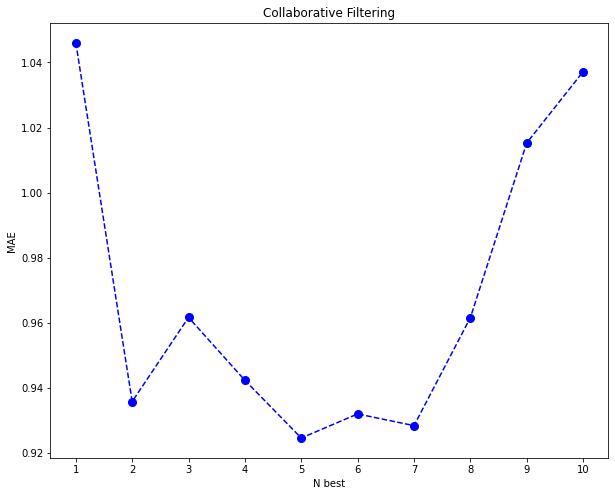

In [26]:
plt.figure(figsize=(10,8))
plt.plot(nMAE,listMAE,'--bo',markersize=8)
plt.xticks(nMAE)
plt.xlabel('N best')
plt.ylabel('MAE')
plt.title('Collaborative Filtering')
plt.show()

### Menghitung prediksi dengan n terbaik. (n=5)

In [51]:
all_mat

array([[0.  , 2.65, 0.  , ..., 0.  , 2.44, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 2.92, 0.  ],
       [0.  , 3.5 , 0.  , ..., 0.  , 3.33, 3.5 ],
       ...,
       [3.45, 3.  , 3.7 , ..., 3.25, 2.75, 2.55],
       [0.  , 4.25, 0.  , ..., 2.7 , 1.7 , 2.05],
       [0.  , 3.75, 0.  , ..., 3.45, 3.15, 2.25]])

In [52]:
##Memprediksi rating kosong
arr0 = []
arr0_pred = []
count=0
n_similarCF = arr_norm[0][0]
for i in range(len(all_mat)):
    for j in range(len(all_mat[i])):
        if all_mat[i][j]==0:
            arr0.append([i+1,j+1,all_mat[i][j]])
            pred = predCF(i+1,j+1,n_similarCF,all_mat)
            arr0_pred.append(pred)
            count+=1

In [53]:
##Normalisasi hasil prediksi
arr0_pred_np = np.array(arr0_pred)
arr0_pred_norm = normalinormalin(0,5,arr0_pred_np)
arr0_pred_norm

array([1.53306782, 0.28444961, 2.43686918, ..., 1.68316165, 2.41481694,
       2.32641899])

In [54]:
#mengisi rating kosong
all_mat_isi = all_mat.copy()
count = 0
for i in range(len(all_mat_isi)):
    for j in range(len(all_mat_isi[i])):
        if (all_mat_isi[i][j]==0):
            all_mat_isi[i][j]=arr0_pred_norm[count]
            count+=1

In [55]:
all_mat

array([[0.  , 2.65, 0.  , ..., 0.  , 2.44, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 2.92, 0.  ],
       [0.  , 3.5 , 0.  , ..., 0.  , 3.33, 3.5 ],
       ...,
       [3.45, 3.  , 3.7 , ..., 3.25, 2.75, 2.55],
       [0.  , 4.25, 0.  , ..., 2.7 , 1.7 , 2.05],
       [0.  , 3.75, 0.  , ..., 3.45, 3.15, 2.25]])

In [56]:
all_mat_isi

array([[1.53306782, 2.65      , 0.28444961, ..., 0.28444961, 2.44      ,
        0.76820985],
       [0.82114161, 2.7484762 , 0.42600844, ..., 0.83370038, 2.92      ,
        0.42600844],
       [1.93065688, 3.5       , 0.45990282, ..., 0.89101886, 3.33      ,
        3.5       ],
       ...,
       [3.45      , 3.        , 3.7       , ..., 3.25      , 2.75      ,
        2.55      ],
       [2.44852819, 4.25      , 0.57064025, ..., 2.7       , 1.7       ,
        2.05      ],
       [2.95524031, 3.75      , 1.11223565, ..., 3.45      , 3.15      ,
        2.25      ]])

## Weighted Slope One

### Preprocess

In [58]:
df_rat = pd.DataFrame()
df_rat['userId']=0
df_rat['itemId']=0
df_rat['rating']=0
idx = 0
for i in range(len(all_mat_isi)):
    for j in range(len(all_mat_isi[i])):
        df_rat.loc[idx] =[int(i+1),int(j+1),all_mat_isi[i][j]]
        idx+=1

In [59]:
df_rat['userId'] = df_rat['userId'].astype(int)
df_rat['itemId'] = df_rat['itemId'].astype(int)

In [60]:
df_rat

,userId,itemId,rating
0,1,1,1.533068
1,1,2,2.650000
2,1,3,0.284450
3,1,4,2.436869
4,1,5,2.920000
...,...,...,...
27680,35,787,3.700000
27681,35,788,2.450000
27682,35,789,3.450000
27683,35,790,3.150000


In [30]:
# df_rat = pd.read_excel('data_rating_isi.xlsx')
# df_rat

,userId,itemId,rating
0,1,1,1.966817
1,1,2,2.650000
2,1,3,0.262453
3,1,4,2.167227
4,1,5,2.920000
...,...,...,...
27680,35,787,3.700000
27681,35,788,2.450000
27682,35,789,3.450000
27683,35,790,3.150000


In [31]:
df_train,df_test = train_test_split(df_rat,test_size=0.2)

In [32]:
df_train

,userId,itemId,rating
23286,30,348,0.356417
18121,23,720,0.147545
27328,35,435,1.072900
24218,31,489,1.087311
26586,34,484,4.250000
...,...,...,...
10898,14,616,2.798579
11621,15,548,2.435620
8840,12,140,0.089536
8329,11,420,0.670228


In [33]:
df_test

,userId,itemId,rating
9110,12,410,1.311656
14235,18,789,0.330978
22049,28,693,0.423233
20154,26,380,1.630349
16904,22,294,1.160036
...,...,...,...
25864,33,553,2.550000
9903,13,412,1.136874
24132,31,403,1.750000
5293,7,548,1.856767


In [34]:
train_mat = get_eval_matrix(df_train)
train_mat

array([[1.966817  , 2.65      , 0.26245267, ..., 0.26245267, 0.        ,
        0.92278557],
       [0.41632262, 2.36059449, 0.41632262, ..., 0.41632262, 2.92      ,
        0.41632262],
       [1.86634887, 3.5       , 0.4238443 , ..., 0.4238443 , 3.33      ,
        3.5       ],
       ...,
       [3.45      , 0.        , 0.        , ..., 0.        , 2.75      ,
        2.55      ],
       [2.87108074, 4.25      , 0.        , ..., 2.7       , 1.7       ,
        2.05      ],
       [0.        , 3.75      , 0.        , ..., 3.45      , 3.15      ,
        0.        ]])

In [35]:
def getPredWSO(userSearch,itemSearch,nSimilar,matx):
    
    ##getSimilarity
    def funcSim(u,matx):
#         print('getSim')
        listtest=[]
        for i in range(len(matx)):
            listtest.append([i+1,stats.pearsonr(matx[u-1],matx[i])[0]])
        listtest.sort(key=lambda row: (row[1]), reverse=True)
#         print(listtest)
        return listtest
    
    
    ##get item similar
    def searchIdxSimilar(listU,n):
#         print('getIdxSim')
        listsimilar = []
        for i in range(1,len(listU)):
            listsimilar.append(listU[i][0])
            if(i==n):
                break
#         print(listsimilar)
        return listsimilar
    
    
    ##get Deviation
    def getDev(devi,devj,matx):
#         print('getDev',devi,devj)        
        atas=0
        tot = len(listSim)
        for i in listSim:
#             print(matx[i-1][devi-1],matx[i-1][devj-1])
#             print()
            atasTemp = matx[i-1][devi-1]-matx[i-1][devj-1]
            atas+=atasTemp    
        return atas/len(listSim)
    
    
    
    ##get Weighted
    def getWeight(devi,devj,matx):
#         print('getWeight',devi,devj)
        totW = 0
        for i in listSim:
            if(matx[i-1][devi-1]!=0 and matx[i-1][devj-1]!=0):
                totW+=1
#         print(totW)
        return totW
    
    ###main func
    similarU = funcSim(userSearch,matx)
    listSim = searchIdxSimilar(similarU,nSimilar)
    atasRat = 0
    bawahRat = 0
#     print('main')
    for i in range(item_num):
        if(i+1 != itemSearch and matx[userSearch-1][i] != 0):
            atasRat+=(getDev(itemSearch,i+1,matx)+matx[userSearch-1][i])*getWeight(itemSearch,i+1,matx)
            bawahRat+=getWeight(itemSearch,i+1,matx)
#     print('hasil',atasRat,bawahRat,atasRat/bawahRat)
    return atasRat/bawahRat

In [36]:
df_test

,userId,itemId,rating
9110,12,410,1.311656
14235,18,789,0.330978
22049,28,693,0.423233
20154,26,380,1.630349
16904,22,294,1.160036
...,...,...,...
25864,33,553,2.550000
9903,13,412,1.136874
24132,31,403,1.750000
5293,7,548,1.856767


In [37]:
##Mencari best-n WSO
listpredWSO=[]
start_time = time.time()
for n in range(1,20+1):
    start_time2 = time.time()
#     print(n)
    ratPredWSO = []
    for idx in range(len(df_test)):
        userSearch=int(df_test.iloc[idx][0])
        itemSearch=int(df_test.iloc[idx][1])
        ratPredWSO.append(getPredWSO(userSearch,itemSearch,n,train_mat))
    print('Waktu n =',n,time.time() - start_time2)
    print('Total Waktu',time.time() - start_time)
    listpredWSO.append(ratPredWSO)

C:\Users\ALDY\AppData\Local\Temp/ipykernel_12384/1918291416.py:61: RuntimeWarning: invalid value encountered in double_scalars
  return atasRat/bawahRat


Waktu n = 1 43.483396768569946
Total Waktu 43.48539161682129
Waktu n = 2 55.219035625457764
Total Waktu 98.70542359352112
Waktu n = 3 61.179511308670044
Total Waktu 159.88493490219116
Waktu n = 4 78.97910857200623
Total Waktu 238.8650417327881
Waktu n = 5 89.17225313186646
Total Waktu 328.03729486465454
Waktu n = 6 95.02116656303406
Total Waktu 423.0584614276886
Waktu n = 7 110.33638191223145
Total Waktu 533.39484333992
Waktu n = 8 125.42964291572571
Total Waktu 658.8244862556458
Waktu n = 9 131.90652012825012
Total Waktu 790.7320032119751
Waktu n = 10 136.466290473938
Total Waktu 927.2003011703491
Waktu n = 11 156.70260524749756
Total Waktu 1083.9029064178467
Waktu n = 12 144.7181167602539
Total Waktu 1228.6210231781006
Waktu n = 13 146.81440544128418
Total Waktu 1375.4364314079285
Waktu n = 14 153.7026596069336
Total Waktu 1529.139091014862
Waktu n = 15 157.62329077720642
Total Waktu 1686.7623817920685
Waktu n = 16 171.32760667800903
Total Waktu 1858.0899884700775
Waktu n = 17 174.37

In [38]:
print('Pengecekan nilai null/nan')
for i in range(len(listpredWSO)):
    print('n=',i+1,':',np.isnan(listpredWSO[i]).sum())

Pengecekan nilai null/nan
n= 1 : 1245
n= 2 : 247
n= 3 : 44
n= 4 : 6
n= 5 : 3
n= 6 : 0
n= 7 : 0
n= 8 : 0
n= 9 : 0
n= 10 : 0
n= 11 : 0
n= 12 : 0
n= 13 : 0
n= 14 : 0
n= 15 : 0
n= 16 : 0
n= 17 : 0
n= 18 : 0
n= 19 : 0
n= 20 : 0


In [39]:
#mengganti null dengan nilai minimal
notnull = []
for i in range(len(listpredWSO)):
    notnull.append(np.nan_to_num(listpredWSO[i], nan=np.nanmin(listpredWSO[i])).tolist())
listpredWSO = notnull

In [40]:
print('Pengecekan nilai null/nan')
for i in range(len(listpredWSO)):
    print('n=',i+1,':',np.isnan(listpredWSO[i]).sum())

Pengecekan nilai null/nan
n= 1 : 0
n= 2 : 0
n= 3 : 0
n= 4 : 0
n= 5 : 0
n= 6 : 0
n= 7 : 0
n= 8 : 0
n= 9 : 0
n= 10 : 0
n= 11 : 0
n= 12 : 0
n= 13 : 0
n= 14 : 0
n= 15 : 0
n= 16 : 0
n= 17 : 0
n= 18 : 0
n= 19 : 0
n= 20 : 0


In [41]:
#rating asli
actualR = df_test['rating'].to_list()

In [42]:
df_test_pred = df_test.copy()
arr_notnorm = []
for i in range(len(listpredWSO)):
    colname = 'n='+str(i+1)
    df_test_pred[colname]=listpredWSO[i]
    print(colname,'MAE =',mean_absolute_error(actualR,listpredWSO[i]))
    arr_notnorm.append([i+1,mean_absolute_error(actualR,listpredWSO[i])])
arr_notnorm.sort(key=lambda row: (row[1]), reverse=False)
print('Best n=',arr_notnorm[0][0],'MAE =',arr_notnorm[0][1])
##jadi n terbaik adalah n=4, sebelum normal

n=1 MAE = 0.7928964754789231
n=2 MAE = 0.559352355592474
n=3 MAE = 0.482951195351581
n=4 MAE = 0.4536463631033719
n=5 MAE = 0.43945609578189654
n=6 MAE = 0.4358425979298053
n=7 MAE = 0.4313884074923706
n=8 MAE = 0.4339199455783324
n=9 MAE = 0.43462339419753393
n=10 MAE = 0.43440286883446266
n=11 MAE = 0.43772791387355076
n=12 MAE = 0.4401126362523966
n=13 MAE = 0.4413610849267525
n=14 MAE = 0.443581710177204
n=15 MAE = 0.44727299407366794
n=16 MAE = 0.44943334364305304
n=17 MAE = 0.45191479809816343
n=18 MAE = 0.45737310938332876
n=19 MAE = 0.45954213605145955
n=20 MAE = 0.4607775458730303
Best n= 7 MAE = 0.4313884074923706


In [43]:
df_test_pred.describe(percentiles=[]).T

,count,mean,std,min,50%,max
userId,5537.0,18.212389,10.024737,1.000000,18.000000,35.000000
itemId,5537.0,395.743543,227.464149,1.000000,398.000000,791.000000
rating,5537.0,1.349831,1.202599,0.000000,0.933481,5.000000
n=1,5537.0,0.897163,1.364840,-0.629887,0.504750,5.658015
n=2,5537.0,1.141898,1.138086,-0.723356,0.828426,5.595433
n=3,5537.0,1.226440,1.057397,-0.711940,0.896915,5.532934
n=4,5537.0,1.257587,1.019039,-0.772298,0.951446,5.028813
n=5,5537.0,1.274968,1.001224,-0.783716,1.018470,5.065982
n=6,5537.0,1.286561,0.983231,-0.681195,1.026021,5.123669
n=7,5537.0,1.296862,0.979277,-0.572406,1.055957,5.171634


In [44]:
nMAE = []
listMAE = []
arr_norm = []
for i in range(len(listpredWSO)):
    colname = 'n='+str(i+1)+'_norm'
    normalPred = normalinormalin(0,5,listpredWSO[i]).tolist()
    df_test_pred[colname]=normalPred
    print(colname,'MAE =',mean_absolute_error(actualR,normalPred))
    arr_norm.append([i+1,mean_absolute_error(actualR,normalPred)])
    nMAE.append(i+1)
    listMAE.append(mean_absolute_error(actualR,normalPred))

arr_norm.sort(key=lambda row: (row[1]), reverse=False)
print('Best n=',arr_norm[0][0],'MAE =',arr_norm[0][1])

##sesudah normal(0-5)

n=1_norm MAE = 0.698369248861837
n=2_norm MAE = 0.6366504260079278
n=3_norm MAE = 0.6133544768294336
n=4_norm MAE = 0.6799508109254274
n=5_norm MAE = 0.6779623239708247
n=6_norm MAE = 0.6396763512118512
n=7_norm MAE = 0.5938609578664792
n=8_norm MAE = 0.5865166919903968
n=9_norm MAE = 0.593205906115566
n=10_norm MAE = 0.5678154461084663
n=11_norm MAE = 0.5747399649231218
n=12_norm MAE = 0.574766146074197
n=13_norm MAE = 0.5754719767720199
n=14_norm MAE = 0.5885542628128696
n=15_norm MAE = 0.605313507429979
n=16_norm MAE = 0.5989287986516401
n=17_norm MAE = 0.598482908923964
n=18_norm MAE = 0.6017485558117853
n=19_norm MAE = 0.6043047883356438
n=20_norm MAE = 0.603618884681654
Best n= 10 MAE = 0.5678154461084663


In [45]:
df_test_pred.describe(percentiles=[]).T

,count,mean,std,min,50%,max
userId,5537.0,18.212389,10.024737,1.000000,18.000000,35.000000
itemId,5537.0,395.743543,227.464149,1.000000,398.000000,791.000000
rating,5537.0,1.349831,1.202599,0.000000,0.933481,5.000000
n=1,5537.0,0.897163,1.364840,-0.629887,0.504750,5.658015
n=2,5537.0,1.141898,1.138086,-0.723356,0.828426,5.595433
n=3,5537.0,1.226440,1.057397,-0.711940,0.896915,5.532934
n=4,5537.0,1.257587,1.019039,-0.772298,0.951446,5.028813
n=5,5537.0,1.274968,1.001224,-0.783716,1.018470,5.065982
n=6,5537.0,1.286561,0.983231,-0.681195,1.026021,5.123669
n=7,5537.0,1.296862,0.979277,-0.572406,1.055957,5.171634


In [46]:
len(listpredWSO)

20

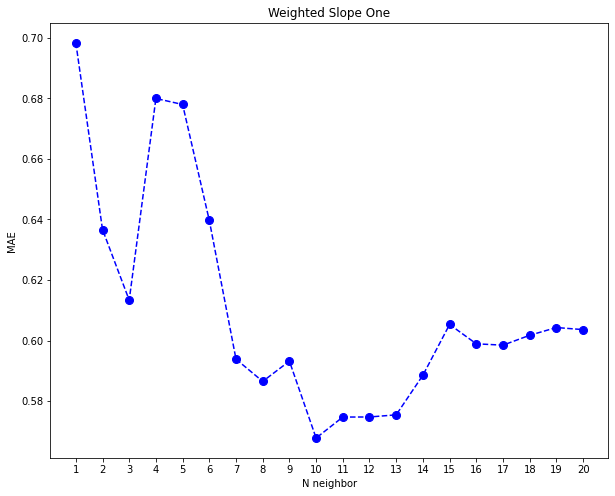

In [47]:
plt.figure(figsize=(10,8))
plt.plot(nMAE,listMAE,'--bo',markersize=8)
plt.xticks(nMAE)
plt.xlabel('N neighbor')
plt.ylabel('MAE')
plt.title('Weighted Slope One')
plt.show()